In [57]:
# --- CELL 1: IMPORT THƯ VIỆN VÀ CÀI ĐẶT CHUNG ---

# Thư viện cơ bản cho xử lý dữ liệu và tính toán
import pandas as pd
import numpy as np

# Thư viện cho trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện Scikit-learn cho Hồi quy Tuyến tính, Random Forest và các độ đo đánh giá
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Thư viện Statsmodels cho các mô hình chuỗi thời gian (ARIMA, ETS) và phân tích
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA as StatsmodelsARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
# from statsmodels.tsa.ets.api import ETSModel # Bỏ comment nếu statsmodels đủ mới
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Thư viện pmdarima cho auto_arima
try:
    from pmdarima import auto_arima
    pmdarima_available = True
except ImportError:
    pmdarima_available = False
    print("Cảnh báo: Thư viện 'pmdarima' chưa được cài đặt. Chức năng auto_arima sẽ không khả dụng.")
    print("Bạn có thể cài đặt bằng lệnh: pip install pmdarima")

# Cài đặt cho Matplotlib
%matplotlib inline

# Cài đặt cho Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_rows', None) # Hiển thị tất cả các hàng
# pd.set_option('display.max_columns', None) # Hiển thị tất cả các cột
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', None)

print("--- Cell 1: Import Thư viện và Cài đặt Chung Hoàn Tất ---")
if pmdarima_available:
    print("Thư viện pmdarima đã sẵn sàng.")

--- Cell 1: Import Thư viện và Cài đặt Chung Hoàn Tất ---
Thư viện pmdarima đã sẵn sàng.


In [58]:
# --- CELL 2: ĐỌC, TIỀN XỬ LÝ VÀ THỐNG KÊ DỮ LIỆU (KHÔNG VẼ BIỂU ĐỒ EDA) ---
print("--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU (CELL 2) ---")

# --- 2.1. THU THẬP DỮ LIỆU ---
file_path = 'World GDP Dataset.csv'
try:
    df_raw_initial = pd.read_csv(file_path)
    df_raw = pd.read_csv(file_path, na_values=['0', 0.0, '']) # '' xử lý ô trống
except FileNotFoundError: print(f"Lỗi: Không tìm thấy file '{file_path}'."); raise
except Exception as e: print(f"Lỗi khi đọc file CSV: {e}"); raise
print("2.1. Đọc dữ liệu thô thành công.")

print("\n--- Thông tin DataFrame df_raw_initial (Đọc thô) ---")
if 'df_raw_initial' in locals():
    print(f"Kích thước: {df_raw_initial.shape[0]} hàng, {df_raw_initial.shape[1]} cột.")
    with pd.option_context('display.max_rows', 6, 'display.max_columns', 10, 'display.show_dimensions', False): # Tóm tắt hơn
        display(df_raw_initial) # Pandas sẽ tự tóm tắt nếu lớn
    df_raw_initial.info(memory_usage=False, verbose=False)
else: print("df_raw_initial chưa được tạo.")

# --- 2.2. XÁC ĐỊNH BIẾN MỤC TIÊU ---
print("\n--- 2.2. Xác định Biến Mục tiêu ---")
print("Biến mục tiêu là giá trị GDP. Cột GDP sẽ được hình thành sau tiền xử lý.")

# --- 2.3. TIỀN XỬ LÝ DỮ LIỆU ---
print("\n--- 2.3. Tiền xử lý dữ liệu ---")
df_raw.dropna(how='all', inplace=True)
rows_before_footer = len(df_raw)
df_raw = df_raw[~df_raw.iloc[:, 0].astype(str).str.contains("©IMF|World Economic Outlook Database|Data source:", na=False, case=False, regex=True)]
print(f"  2.3.1.1. Làm sạch: Loại bỏ {rows_before_footer - len(df_raw)} dòng footer/ghi chú.")
df_raw.rename(columns={df_raw.columns[0]: 'Country Name'}, inplace=True)
df_raw.dropna(subset=['Country Name'], inplace=True)
df_raw.reset_index(drop=True, inplace=True)
print("  2.3.1.2. Đổi tên cột quốc gia, loại bỏ dòng Country Name NaN hoàn tất.")
print(f"  df_raw sau làm sạch cơ bản: {df_raw.shape[0]} hàng, {df_raw.shape[1]} cột.")
with pd.option_context('display.max_rows', 6, 'display.max_columns', 10, 'display.show_dimensions', False):
    display(df_raw.head(3)) # Chỉ hiển thị 3 dòng đầu

print("\n  --- 2.3.2. Khám phá Dữ liệu Ban đầu (EDA trên df_raw - Chỉ thống kê) ---")
year_columns_global = df_raw.columns[1:]
df_raw_eda_stats_global = df_raw.copy()
for col in year_columns_global:
    df_raw_eda_stats_global[col] = pd.to_numeric(df_raw_eda_stats_global[col], errors='coerce')
missing_yearly_stats_global = df_raw_eda_stats_global[year_columns_global].isnull().sum()
print(f"\n    Tổng NaN theo năm (Top 3):"); display(missing_yearly_stats_global.sort_values(ascending=False).head(3).to_frame(name='Số NaN'))
if len(year_columns_global) > 0:
    sample_years_stats_global = [str(year_columns_global[0]), str(year_columns_global[len(year_columns_global)//2]), str(year_columns_global[-1])]
    existing_sample_years_global = [yr for yr in sample_years_stats_global if yr in df_raw_eda_stats_global.columns]
    if existing_sample_years_global:
        print(f"\n    Thống kê GDP cho các năm ({', '.join(existing_sample_years_global)}):"); display(df_raw_eda_stats_global[existing_sample_years_global].describe().T.head(3)) # Transpose và head
    last_year_stats_global = str(year_columns_global[-1])
    if last_year_stats_global in df_raw_eda_stats_global.columns:
        print(f"\n    Top 3 GDP cao nhất năm {last_year_stats_global}:")
        display(df_raw_eda_stats_global[['Country Name', last_year_stats_global]].sort_values(by=last_year_stats_global, ascending=False).head(3).reset_index(drop=True))

# --- 2.5. CHUYỂN ĐỔI DỮ LIỆU ---
print("\n--- 2.5. Chuyển đổi dữ liệu ---")
print("  --- 2.5.1. Chuyển đổi Wide sang Long (Melting df_raw) ---")
try:
    df_long = pd.melt(df_raw, id_vars=['Country Name'], var_name='Year', value_name='GDP')
except KeyError as e: print(f"Lỗi melt: {e}"); raise
print(f"  Chuyển đổi wide sang long thành công. df_long: {df_long.shape[0]} hàng, {df_long.shape[1]} cột.")
with pd.option_context('display.max_rows', 6, 'display.show_dimensions', False): display(df_long)

print("\n  --- 2.5.2. Chuyển đổi kiểu dữ liệu và Xử lý NaN cuối cùng cho df_long ---")
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
if df_long['GDP'].dtype == 'object': df_long['GDP'] = df_long['GDP'].astype(str).str.replace(',', '', regex=False)
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')
print("  Chuyển đổi kiểu dữ liệu Year, GDP trong df_long hoàn tất.")
rows_before_final_dropna_long = len(df_long)
df_long.dropna(subset=['Year', 'GDP'], inplace=True)
print(f"  Xử lý NaN cuối cùng trong df_long: Loại bỏ {rows_before_final_dropna_long - len(df_long)} dòng.")

print("\n  --- 2.5.3. Sắp xếp dữ liệu df_long ---")
df_long.sort_values(by=['Country Name', 'Year'], inplace=True)
df_long['Year'] = df_long['Year'].astype(int)
df_long.reset_index(drop=True, inplace=True)
print("  Sắp xếp df_long và chuyển Year về int hoàn tất.")

# --- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long cuối cùng) ---
print("\n\n--- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long CUỐI CÙNG) ---")
if 'df_long' in locals() and not df_long.empty:
    print(f"Kích thước cuối cùng: {df_long.shape[0]} hàng × {df_long.shape[1]} cột.")
    print(f"Tên cột: {df_long.columns.tolist()}"); print("\nKiểu dữ liệu:"); print(df_long.dtypes)
    print("\nGiá trị duy nhất/cột:");
    for col in df_long.columns: print(f"  - {col}: {df_long[col].nunique()}")
    print("\nKiểm tra NaN:"); print(df_long.isnull().sum())
    print("\nThống kê mô tả:"); display(df_long.describe())
    print(f"\nPhạm vi năm: {df_long['Year'].min()} - {df_long['Year'].max()}")
    print(f"Số quốc gia: {df_long['Country Name'].nunique()}")
    print(f"Số năm dữ liệu TB/quốc gia: {df_long.groupby('Country Name')['Year'].count().mean():.2f}")
    print("\nHiển thị tóm tắt df_long cuối cùng:")
    with pd.option_context('display.max_rows', 10, 'display.show_dimensions', True): # Hiển thị 10 dòng (5 đầu, 5 cuối)
        display(df_long)
else: print("df_long chưa được tạo hoặc rỗng.")
print("\n--- KẾT THÚC CHƯƠNG 2: XỬ LÝ DỮ LIỆU (CELL 2) ---")

--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU (CELL 2) ---
2.1. Đọc dữ liệu thô thành công.

--- Thông tin DataFrame df_raw_initial (Đọc thô) ---
Kích thước: 230 hàng, 45 cột.


,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,...,2019,2020,2021,2022,2023
0,Afghanistan,0.000,0.000,0.000,0.000,...,18.876,20.136,0.000,0.000,0.000
1,Albania,1.946,2.229,2.296,2.319,...,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,...,171.680,144.922,162.711,187.155,190.254
...,...,...,...,...,...,...,...,...,...,...,...
227,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
229,"©IMF, 2022",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Columns: 45 entries, GDP, current prices (Billions of U.S. dollars) to 2023
dtypes: float64(44), object(1)
--- 2.2. Xác định Biến Mục tiêu ---
Biến mục tiêu là giá trị GDP. Cột GDP sẽ được hình thành sau tiền xử lý.

--- 2.3. Tiền xử lý dữ liệu ---
  2.3.1.1. Làm sạch: Loại bỏ 1 dòng footer/ghi chú.
  2.3.1.2. Đổi tên cột quốc gia, loại bỏ dòng Country Name NaN hoàn tất.
  df_raw sau làm sạch cơ bản: 196 hàng, 45 cột.


,Country Name,1980,1981,1982,1983,...,2019,2020,2021,2022,2023
0,Afghanistan,NaN,NaN,NaN,NaN,...,18.876,20.136,NaN,NaN,NaN
1,Albania,1.946,2.229,2.296,2.319,...,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,...,171.680,144.922,162.711,187.155,190.254



  --- 2.3.2. Khám phá Dữ liệu Ban đầu (EDA trên df_raw - Chỉ thống kê) ---

    Tổng NaN theo năm (Top 3):


,Số NaN
1980,50
1982,50
1983,50



    Thống kê GDP cho các năm (1980, 2002, 2023):


,count,mean,std,min,25%,50%,75%,max
1980,146.000,76.974,275.705,0.032,1.921,6.967,40.359,2857.325
2002,193.000,180.909,878.732,0.017,2.257,9.719,70.282,10929.100
2023,190.000,556.407,2427.762,0.068,10.902,43.337,270.734,26185.210



    Top 3 GDP cao nhất năm 2023:


,Country Name,2023
0,United States,26185.210
1,"China, People's Republic of",19243.974
2,Japan,4365.976



--- 2.5. Chuyển đổi dữ liệu ---
  --- 2.5.1. Chuyển đổi Wide sang Long (Melting df_raw) ---
  Chuyển đổi wide sang long thành công. df_long: 8624 hàng, 3 cột.


,Country Name,Year,GDP
0,Afghanistan,1980,NaN
1,Albania,1980,1.946
2,Algeria,1980,42.346
...,...,...,...
8621,Yemen,2023,28.099
8622,Zambia,2023,28.798
8623,Zimbabwe,2023,37.303



  --- 2.5.2. Chuyển đổi kiểu dữ liệu và Xử lý NaN cuối cùng cho df_long ---
  Chuyển đổi kiểu dữ liệu Year, GDP trong df_long hoàn tất.
  Xử lý NaN cuối cùng trong df_long: Loại bỏ 772 dòng.

  --- 2.5.3. Sắp xếp dữ liệu df_long ---
  Sắp xếp df_long và chuyển Year về int hoàn tất.


--- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long CUỐI CÙNG) ---
Kích thước cuối cùng: 7852 hàng × 3 cột.
Tên cột: ['Country Name', 'Year', 'GDP']

Kiểu dữ liệu:
Country Name     object
Year              int32
GDP             float64
dtype: object

Giá trị duy nhất/cột:
  - Country Name: 196
  - Year: 44
  - GDP: 7052

Kiểm tra NaN:
Country Name    0
Year            0
GDP             0
dtype: int64

Thống kê mô tả:


,Year,GDP
count,7852.000,7852.000
mean,2002.742,263.121
std,12.397,1245.565
min,1980.000,0.014
25%,1993.000,3.260
50%,2003.000,15.974
75%,2013.000,99.016
max,2023.000,26185.210



Phạm vi năm: 1980 - 2023
Số quốc gia: 196
Số năm dữ liệu TB/quốc gia: 40.06

Hiển thị tóm tắt df_long cuối cùng:


,Country Name,Year,GDP
0,Afghanistan,2002,4.367
1,Afghanistan,2003,4.553
2,Afghanistan,2004,5.146
3,Afghanistan,2005,6.167
4,Afghanistan,2006,6.925
...,...,...,...
7847,Zimbabwe,2019,22.995
7848,Zimbabwe,2020,23.181
7849,Zimbabwe,2021,32.868
7850,Zimbabwe,2022,38.280



--- KẾT THÚC CHƯƠNG 2: XỬ LÝ DỮ LIỆU (CELL 2) ---


--- BẮT ĐẦU TRỰC QUAN HÓA KHÁM PHÁ DỮ LIỆU (CELL 2.1) ---

--- A. EDA trên df_raw_eda_stats_global (Dữ liệu Wide, trước khi Melt) ---


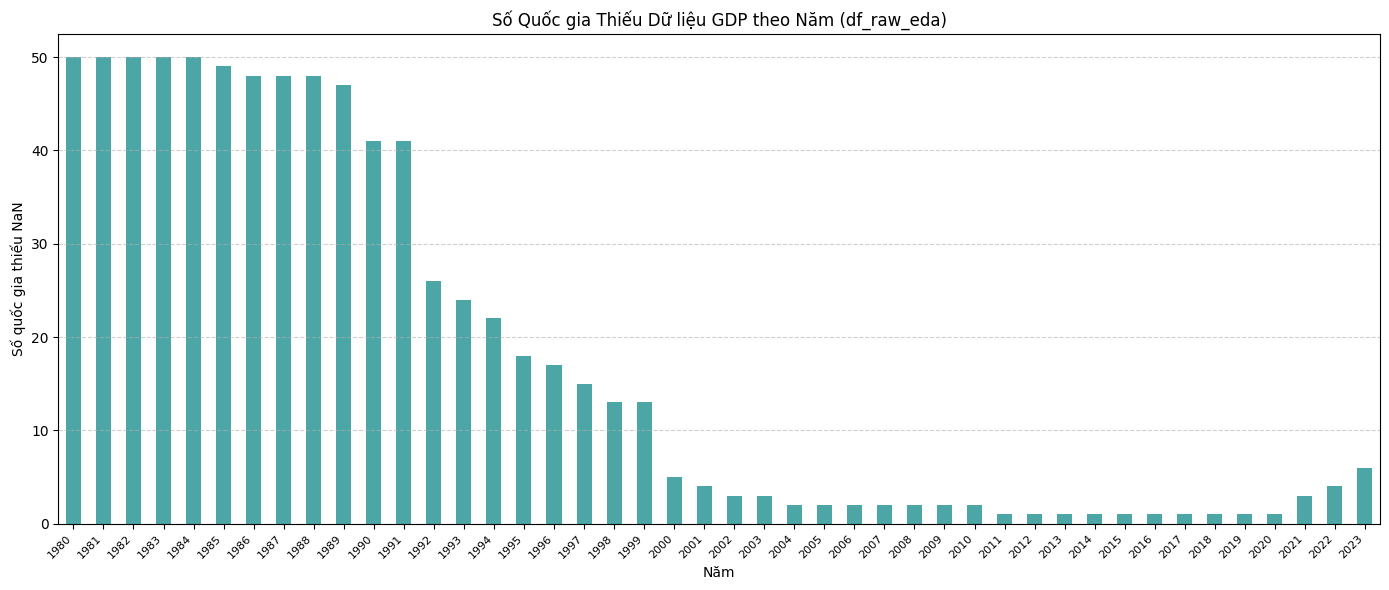

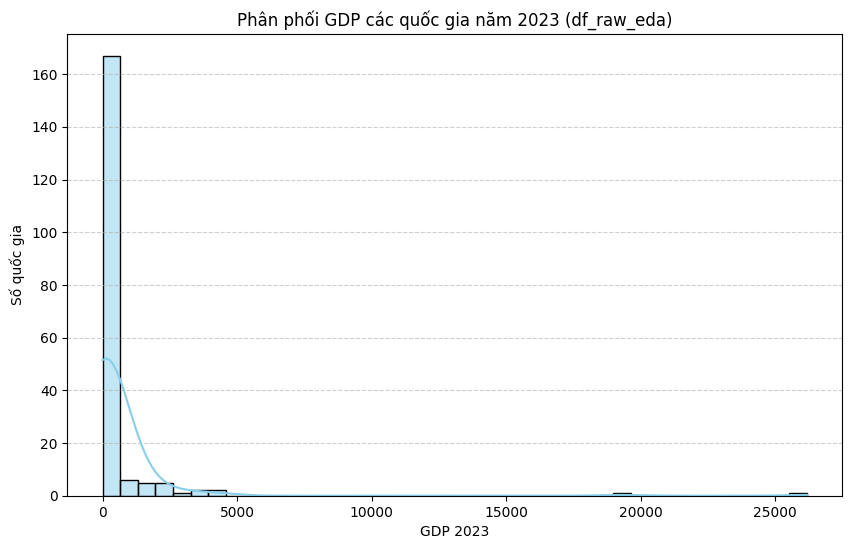

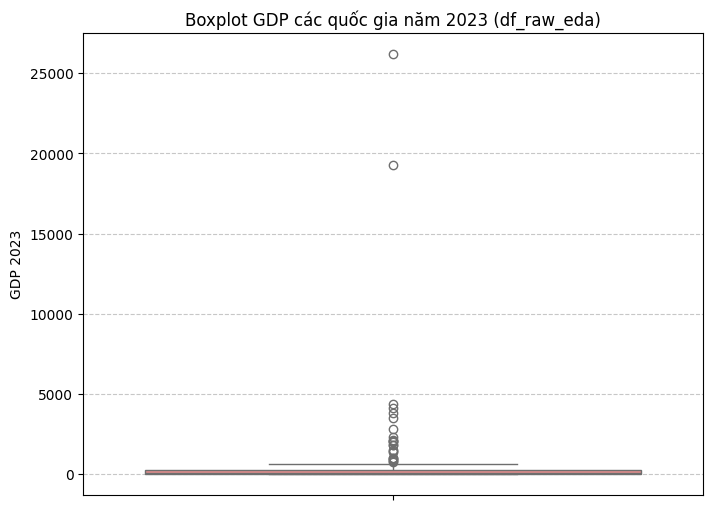

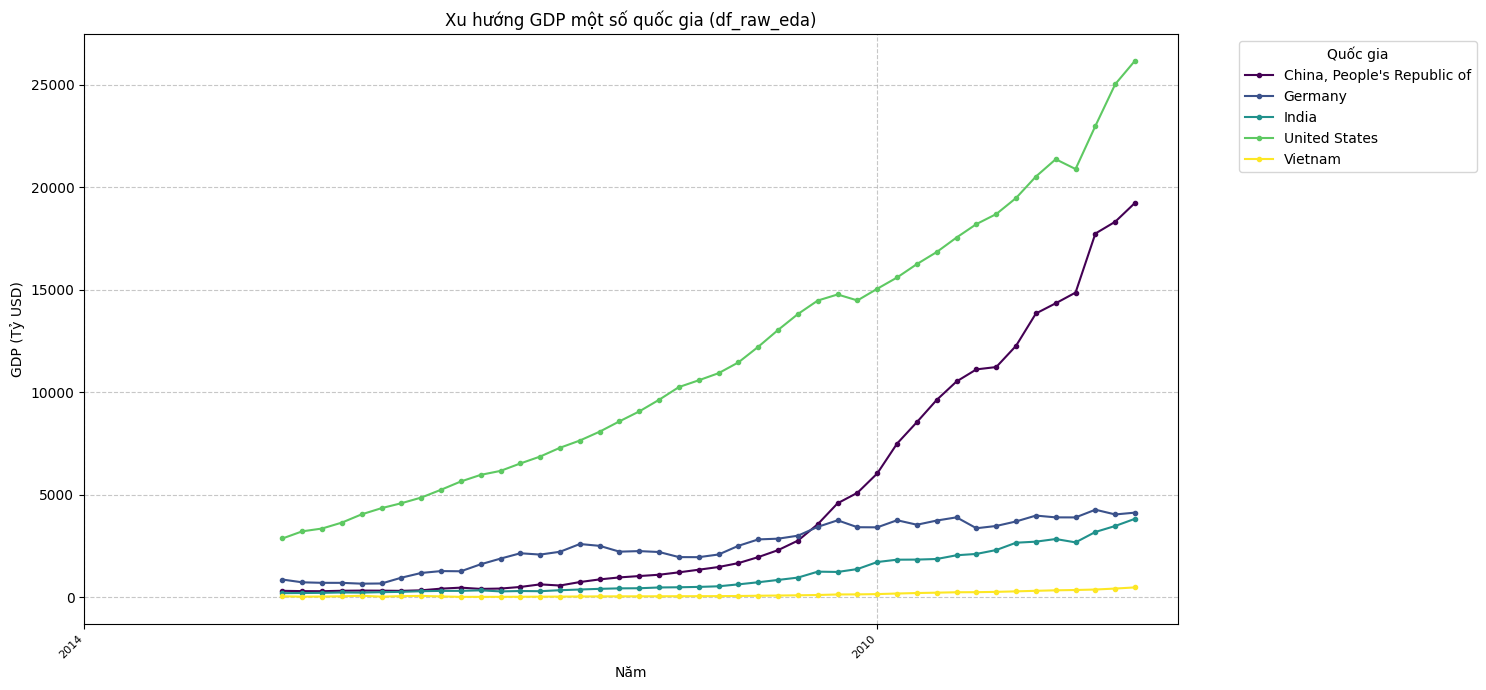



--- B. EDA trên df_long (Dữ liệu Long cuối cùng) ---


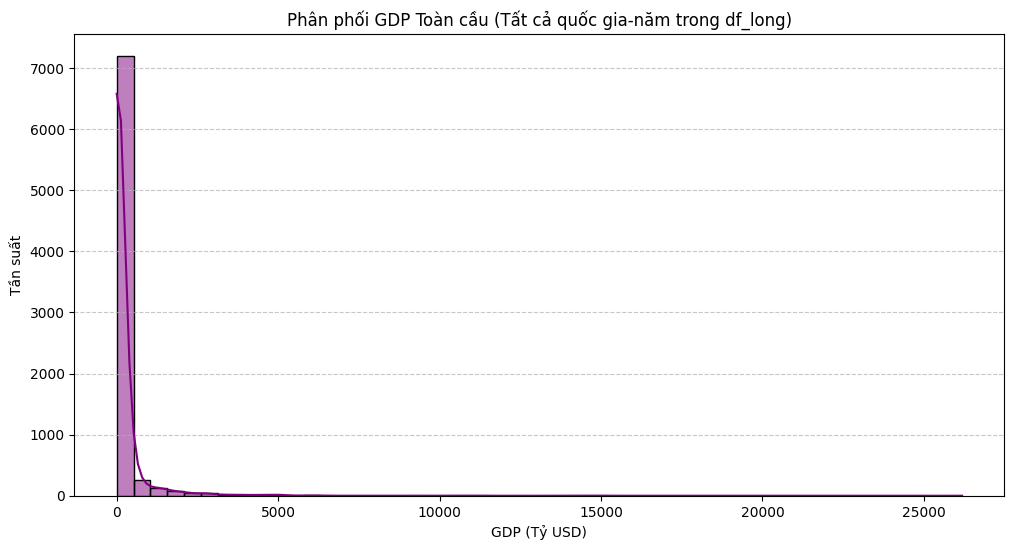

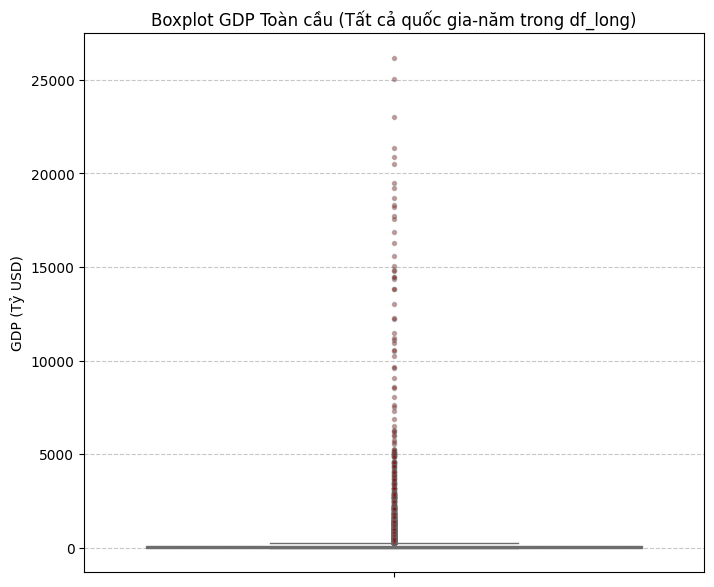

C:\Users\PC GAME\AppData\Local\Temp\ipykernel_24816\2961476731.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(10, 6)); sns.boxplot(x='Year_Group', y='GDP', data=df_long_temp_viz_global.dropna(subset=['Year_Group']), palette='coolwarm', showfliers=False)


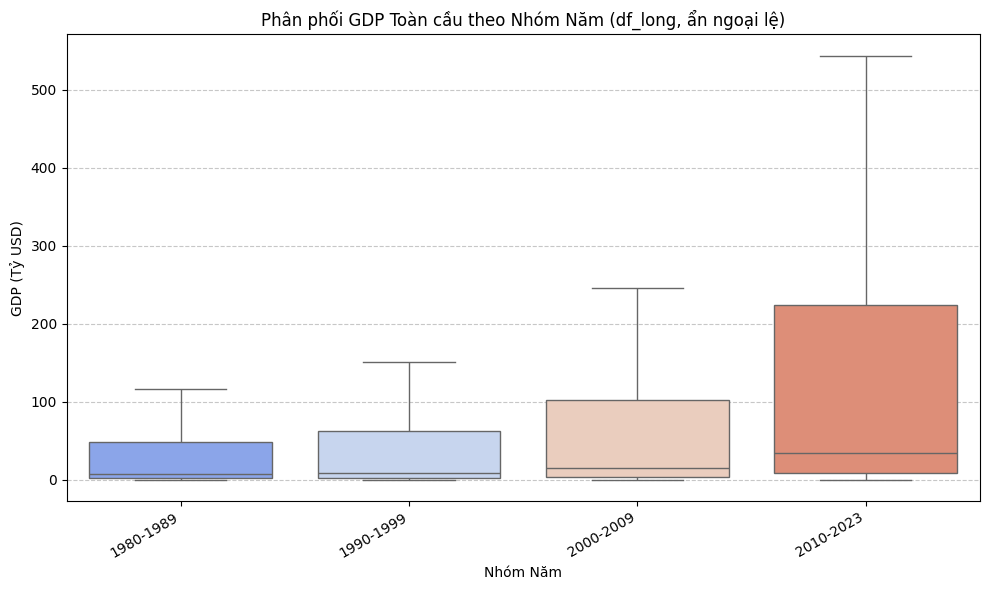


--- KẾT THÚC TRỰC QUAN HÓA KHÁM PHÁ DỮ LIỆU (CELL 2.1) ---


In [59]:
# --- CELL 2.1: TRỰC QUAN HÓA KHÁM PHÁ DỮ LIỆU (EDA) ---
print("--- BẮT ĐẦU TRỰC QUAN HÓA KHÁM PHÁ DỮ LIỆU (CELL 2.1) ---")

# --- A. TRỰC QUAN HÓA TRÊN df_raw_eda_stats (Dữ liệu Wide) ---
if 'df_raw_eda_stats_global' in locals() and not df_raw_eda_stats_global.empty: # Đổi tên biến cho rõ ràng
    print("\n--- A. EDA trên df_raw_eda_stats_global (Dữ liệu Wide, trước khi Melt) ---")
    if 'missing_yearly_stats_global' in locals():
        plt.figure(figsize=(14, 6)); missing_yearly_stats_global.plot(kind='bar', color='teal', alpha=0.7)
        plt.title('Số Quốc gia Thiếu Dữ liệu GDP theo Năm (df_raw_eda)'); plt.xlabel('Năm'); plt.ylabel('Số quốc gia thiếu NaN')
        plt.xticks(rotation=45, ha='right', fontsize=8); plt.grid(axis='y', linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()
    if 'year_columns_global' in locals() and len(year_columns_global) > 0:
        last_year_viz_global = str(year_columns_global[-1])
        if last_year_viz_global in df_raw_eda_stats_global.columns:
            plt.figure(figsize=(10, 6)); sns.histplot(df_raw_eda_stats_global[last_year_viz_global].dropna(), kde=True, bins=40, color='skyblue', edgecolor='black')
            plt.title(f'Phân phối GDP các quốc gia năm {last_year_viz_global} (df_raw_eda)'); plt.xlabel(f'GDP {last_year_viz_global}'); plt.ylabel('Số quốc gia'); plt.grid(axis='y', linestyle='--', alpha=0.6); plt.show()
            plt.figure(figsize=(8, 6)); sns.boxplot(y=df_raw_eda_stats_global[last_year_viz_global].dropna(), color='lightcoral')
            plt.title(f'Boxplot GDP các quốc gia năm {last_year_viz_global} (df_raw_eda)'); plt.ylabel(f'GDP {last_year_viz_global}'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()
    sample_countries_viz_global = ['United States', 'China, People\'s Republic of', 'Germany', 'India', 'Vietnam']
    df_sample_viz_global = df_raw_eda_stats_global[df_raw_eda_stats_global['Country Name'].isin(sample_countries_viz_global)].copy()
    if not df_sample_viz_global.empty and 'year_columns_global' in locals() and len(year_columns_global) > 0:
        df_sample_viz_global.set_index('Country Name', inplace=True)
        existing_years_sample_viz_global = [col for col in year_columns_global if col in df_sample_viz_global.columns]
        if existing_years_sample_viz_global:
            plt.figure(figsize=(15, 7)); df_sample_viz_global[existing_years_sample_viz_global].T.plot(ax=plt.gca(), colormap='viridis', marker='.')
            plt.title('Xu hướng GDP một số quốc gia (df_raw_eda)'); plt.xlabel('Năm'); plt.ylabel('GDP (Tỷ USD)')
            plt.legend(title='Quốc gia', bbox_to_anchor=(1.05, 1), loc='upper left'); plt.grid(True, linestyle='--', alpha=0.7)
            ax = plt.gca(); step_viz_global = max(1, len(existing_years_sample_viz_global) // 10); ax.set_xticks(ax.get_xticks()[::step_viz_global])
            plt.xticks(rotation=45, ha='right', fontsize=8); plt.tight_layout(); plt.show()
else: print("df_raw_eda_stats_global chưa được tạo hoặc rỗng.")

# --- B. TRỰC QUAN HÓA TRÊN df_long (Dữ liệu Long cuối cùng) ---
if 'df_long' in locals() and not df_long.empty:
    print("\n\n--- B. EDA trên df_long (Dữ liệu Long cuối cùng) ---")
    plt.figure(figsize=(12, 6)); sns.histplot(df_long['GDP'], kde=True, bins=50, color='purple', edgecolor='black')
    plt.title('Phân phối GDP Toàn cầu (Tất cả quốc gia-năm trong df_long)'); plt.xlabel('GDP (Tỷ USD)'); plt.ylabel('Tần suất'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()
    plt.figure(figsize=(8, 7)); sns.boxplot(y=df_long['GDP'], color='salmon', flierprops={'marker':'o', 'markersize':3, 'markerfacecolor':'darkred', 'alpha':0.4})
    plt.title('Boxplot GDP Toàn cầu (Tất cả quốc gia-năm trong df_long)'); plt.ylabel('GDP (Tỷ USD)'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()
    bins_viz_long_global = [1979, 1990, 2000, 2010, df_long['Year'].max() + 1]
    labels_viz_long_global = ['1980-1989', '1990-1999', '2000-2009', f'2010-{df_long["Year"].max()}']
    df_long_temp_viz_global = df_long.copy()
    df_long_temp_viz_global['Year_Group'] = pd.cut(df_long_temp_viz_global['Year'], bins=bins_viz_long_global, labels=labels_viz_long_global, right=False, include_lowest=True)
    if df_long_temp_viz_global['Year_Group'].isnull().any(): print("Cảnh báo: NaN trong 'Year_Group' khi vẽ boxplot nhóm năm.");
    plt.figure(figsize=(10, 6)); sns.boxplot(x='Year_Group', y='GDP', data=df_long_temp_viz_global.dropna(subset=['Year_Group']), palette='coolwarm', showfliers=False)
    plt.title('Phân phối GDP Toàn cầu theo Nhóm Năm (df_long, ẩn ngoại lệ)'); plt.xlabel('Nhóm Năm'); plt.ylabel('GDP (Tỷ USD)')
    plt.xticks(rotation=30, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()
else: print("df_long chưa được tạo hoặc rỗng.")
print("\n--- KẾT THÚC TRỰC QUAN HÓA KHÁM PHÁ DỮ LIỆU (CELL 2.1) ---")




--- BẮT ĐẦU M2_1_ARIMA_Auto CHO VIETNAM ---
Dữ liệu GDP cho Vietnam (5 dòng đầu):


C:\Users\PC GAME\AppData\Local\Temp\ipykernel_24816\2026816588.py:29: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  country_ts_data['Year'] = pd.to_datetime(country_ts_data['Year'].astype(str), format='%Y').dt.to_period('A')


Year
1980   35.357
1981   17.617
1982   23.369
1983   35.204
1984   61.171
Freq: Y-DEC, Name: GDP, dtype: float64

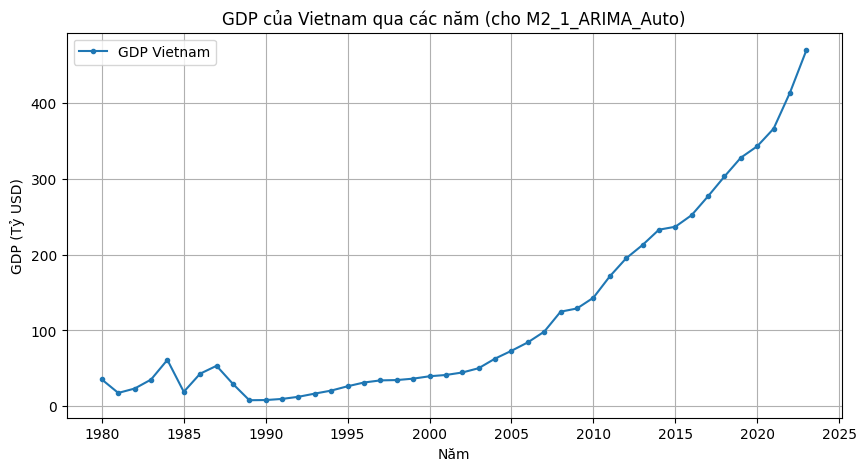

In [60]:
# --- MÔ HÌNH 2.1: ARIMA VỚI THAM SỐ TỰ ĐỘNG ---

# === THAM SỐ CHUNG CHO KHỐI MÔ HÌNH NÀY ===
MODEL_ID = "M2_1_ARIMA_Auto" # ID để định danh các biến của mô hình này
COUNTRY_TO_ANALYZE = 'Vietnam' # <<--- THAY ĐỔI QUỐC GIA Ở ĐÂY
TEST_SIZE_RATIO = 0.2 # Tỷ lệ dữ liệu cho tập kiểm tra
N_FUTURE_YEARS = 5 # Số năm dự báo cho tương lai
# ==========================================

print(f"\n\n--- BẮT ĐẦU {MODEL_ID} CHO {COUNTRY_TO_ANALYZE.upper()} ---")

# 1. Lọc và chuẩn bị chuỗi thời gian
if 'df_long' not in locals() or df_long.empty:
    print(f"Lỗi: df_long chưa được tạo hoặc rỗng. Vui lòng chạy Cell 2 trước.")
    # Khai báo các biến sẽ được tạo ở cell này là None để các cell sau không lỗi nếu dừng ở đây
    ts_gdp = None
    best_order = None
    arima_results = None
    arima_results_final = None
else:
    country_ts_data = df_long[df_long['Country Name'] == COUNTRY_TO_ANALYZE].copy()
    country_ts_data.sort_values('Year', inplace=True)

    if country_ts_data.empty:
        print(f"Không tìm thấy dữ liệu cho '{COUNTRY_TO_ANALYZE}'. Bỏ qua {MODEL_ID} cho quốc gia này.")
        ts_gdp = None; best_order = None; arima_results = None; arima_results_final = None
    else:
        try:
            country_ts_data['Year'] = pd.to_datetime(country_ts_data['Year'].astype(str), format='%Y').dt.to_period('A')
            country_ts_data.set_index('Year', inplace=True)
        except Exception as e:
            print(f"Lỗi khi tạo PeriodIndex cho Year: {e}. Sử dụng Year làm index số nguyên.")
            country_ts_data.set_index('Year', inplace=True)

        ts_gdp = country_ts_data['GDP'] # Chuỗi thời gian GDP đơn biến
        
        print(f"Dữ liệu GDP cho {COUNTRY_TO_ANALYZE} (5 dòng đầu):"); display(ts_gdp.head())
        
        plt.figure(figsize=(10,5))
        plot_index = ts_gdp.index.to_timestamp() if isinstance(ts_gdp.index, pd.PeriodIndex) else ts_gdp.index
        plt.plot(plot_index, ts_gdp, marker='.', label=f'GDP {COUNTRY_TO_ANALYZE}')
        plt.title(f'GDP của {COUNTRY_TO_ANALYZE} qua các năm (cho {MODEL_ID})')
        plt.xlabel('Năm'); plt.ylabel('GDP (Tỷ USD)'); plt.grid(True); plt.legend(); plt.show()

In [61]:
# --- CELL A2: {MODEL_ID} - KIỂM TRA TÍNH DỪNG VÀ TÌM THAM SỐ ---

best_order = None # Khởi tạo lại ở đây để đảm bảo nó được gán giá trị trong cell này

if 'ts_gdp' in locals() and ts_gdp is not None and not ts_gdp.empty:
    print(f"\n--- {MODEL_ID}: Kiểm tra tính dừng của chuỗi GDP cho {COUNTRY_TO_ANALYZE} ---")
    adf_test_result = adfuller(ts_gdp.dropna())
    print(f'ADF Statistic: {adf_test_result[0]:.4f}, p-value: {adf_test_result[1]:.4f}')
    if adf_test_result[1] > 0.05: print("  Kết luận: Chuỗi có thể không dừng (p-value > 0.05).")
    else: print("  Kết luận: Chuỗi có thể dừng (p-value <= 0.05).")

    print(f"\n--- {MODEL_ID}: Tìm kiếm tham số ARIMA tối ưu bằng auto_arima ---")
    
    # Sử dụng toàn bộ chuỗi ts_gdp để auto_arima tìm tham số
    # Việc chia train/test sẽ thực hiện sau cho huấn luyện và đánh giá
    min_obs_for_auto = 10 
    if pmdarima_available and len(ts_gdp) >= min_obs_for_auto :
        try:
            auto_arima_model = auto_arima(ts_gdp,
                                          start_p=0, start_q=0,
                                          max_p=3, max_q=3, max_d=2,
                                          start_P=0, seasonal=False, m=1,
                                          trace=False, # Đặt True để xem chi tiết
                                          error_action='ignore',
                                          suppress_warnings=True,
                                          stepwise=True,
                                          information_criterion='aic') 

            print(f"\n--- {MODEL_ID}: Thông số ARIMA tối ưu được tìm thấy ---")
            # print(auto_arima_model.summary()) # Có thể bỏ comment nếu muốn xem chi tiết
            best_order = auto_arima_model.order
            print(f"Best ARIMA order (p,d,q) cho {MODEL_ID}: {best_order}")

        except Exception as e:
            print(f"Lỗi khi chạy auto_arima cho {MODEL_ID}: {e}")
            print(f"Sử dụng bộ tham số ARIMA mặc định (1,1,1) cho {MODEL_ID}.")
            best_order = (1,1,1)
    else:
        if not pmdarima_available: print(f"pmdarima không khả dụng. Sử dụng (1,1,1) cho {MODEL_ID}.")
        else: print(f"Không đủ dữ liệu ({len(ts_gdp)} điểm) cho auto_arima. Sử dụng (1,1,1) cho {MODEL_ID}.")
        best_order = (1,1,1)
else:
    print(f"Biến ts_gdp cho {MODEL_ID} chưa được tạo hoặc rỗng.")
    if 'best_order' in locals(): del best_order # Xóa nếu không thành công


--- M2_1_ARIMA_Auto: Kiểm tra tính dừng của chuỗi GDP cho Vietnam ---
ADF Statistic: 4.3529, p-value: 1.0000
  Kết luận: Chuỗi có thể không dừng (p-value > 0.05).

--- M2_1_ARIMA_Auto: Tìm kiếm tham số ARIMA tối ưu bằng auto_arima ---


c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklea


--- M2_1_ARIMA_Auto: Thông số ARIMA tối ưu được tìm thấy ---
Best ARIMA order (p,d,q) cho M2_1_ARIMA_Auto: (3, 2, 0)


c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- M2_1_ARIMA_Auto: Huấn luyện Mô hình ARIMA với order (3, 2, 0) ---
Kích thước tập huấn luyện: 35 (1980 - 2014)
Kích thước tập kiểm tra: 9 (2015 - 2023)

--- M2_1_ARIMA_Auto: Tóm tắt Mô hình ARIMA đã huấn luyện ---
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   35
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -130.549
Date:                Mon, 26 May 2025   AIC                            269.098
Time:                        00:15:57   BIC                            275.084
Sample:                    12-31-1980   HQIC                           271.112
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

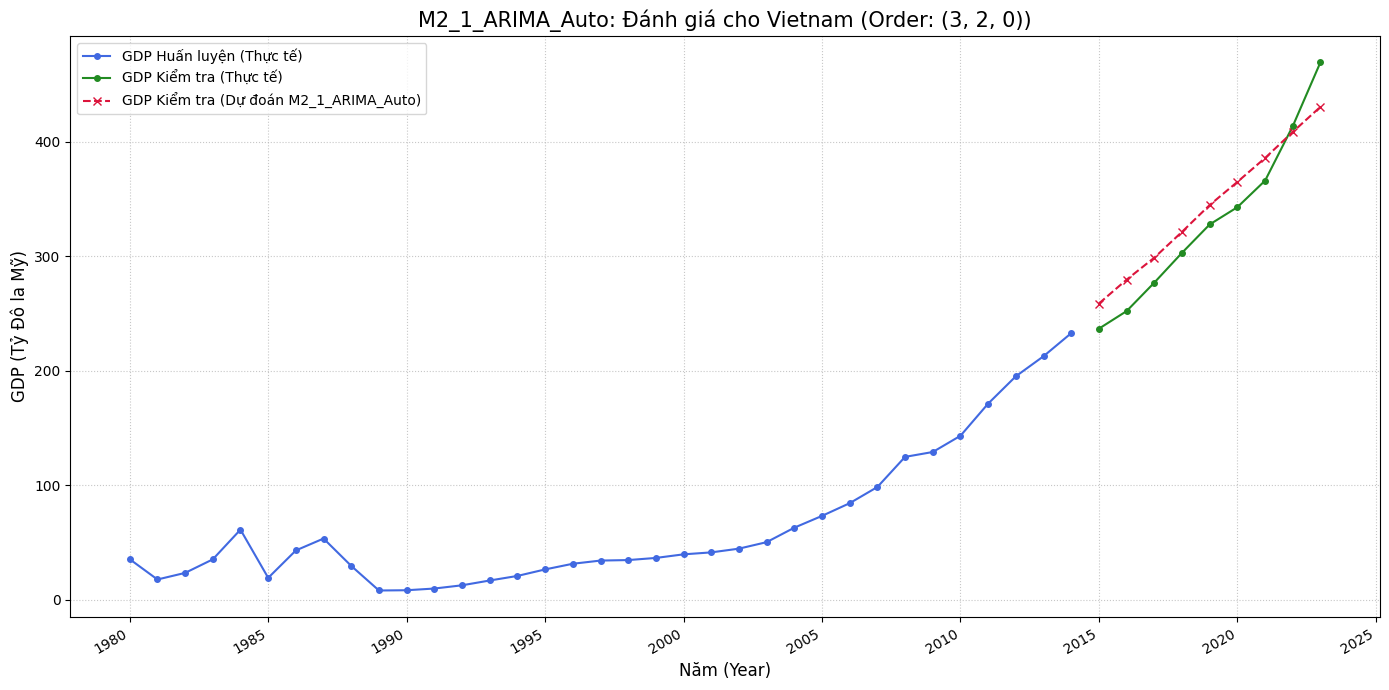

In [62]:
# --- CELL A3: {MODEL_ID} - HUẤN LUYỆN VÀ ĐÁNH GIÁ ---

arima_results = None 
predictions_arima_test = None
r2_arima, mae_arima, rmse_arima, mape_arima = np.nan, np.nan, np.nan, np.nan # Khởi tạo metrics

if 'ts_gdp' in locals() and ts_gdp is not None and \
   'best_order' in locals() and best_order is not None and not ts_gdp.empty:
    
    n_obs = len(ts_gdp)
    n_train = int(n_obs * (1 - TEST_SIZE_RATIO)) # Sử dụng TEST_SIZE_RATIO đã định nghĩa
    train_ts = ts_gdp[:n_train]
    test_ts = ts_gdp[n_train:]
    
    print(f"\n--- {MODEL_ID}: Huấn luyện Mô hình ARIMA với order {best_order} ---")
    print(f"Kích thước tập huấn luyện: {len(train_ts)} ({train_ts.index.min()} - {train_ts.index.max()})")
    print(f"Kích thước tập kiểm tra: {len(test_ts)} ({test_ts.index.min()} - {test_ts.index.max()})")

    if len(test_ts) < 1:
        print(f"Tập kiểm tra quá nhỏ ({len(test_ts)} điểm), không thể đánh giá {MODEL_ID}.")
    else:
        try:
            model_arima_sm = StatsmodelsARIMA(train_ts, order=best_order)
            arima_results = model_arima_sm.fit() 
            
            print(f"\n--- {MODEL_ID}: Tóm tắt Mô hình ARIMA đã huấn luyện ---")
            print(arima_results.summary())

            n_test_periods = len(test_ts)
            predictions_arima_test = arima_results.forecast(steps=n_test_periods)
            predictions_arima_test.index = test_ts.index

            print(f"\n--- {MODEL_ID}: Đánh giá Mô hình ARIMA trên tập Kiểm tra ---")
            r2_arima = r2_score(test_ts, predictions_arima_test)
            mae_arima = mean_absolute_error(test_ts, predictions_arima_test)
            rmse_arima = np.sqrt(mean_squared_error(test_ts, predictions_arima_test))
            
            y_true_m = test_ts.copy(); y_pred_m = predictions_arima_test.copy()
            zero_mask = (np.abs(y_true_m) < 1e-9)
            y_true_f = y_true_m[~zero_mask]; y_pred_f = y_pred_m[~zero_mask]
            if len(y_true_f) > 0: mape_arima = np.mean(np.abs((y_true_f - y_pred_f) / y_true_f)) * 100
            else: mape_arima = np.nan
            
            print(f"R-squared (Test): {r2_arima:.4f}")
            print(f"MAE (Test): {mae_arima:.2f}")
            print(f"RMSE (Test): {rmse_arima:.2f}")
            if not np.isnan(mape_arima): print(f"MAPE (Test): {mape_arima:.2f}% (Tính trên {len(y_true_f)} điểm)")
            else: print("MAPE (Test): Không thể tính.")

            plt.figure(figsize=(14, 7))
            idx_train = train_ts.index.to_timestamp() if isinstance(train_ts.index, pd.PeriodIndex) else train_ts.index
            idx_test = test_ts.index.to_timestamp() if isinstance(test_ts.index, pd.PeriodIndex) else test_ts.index
            idx_pred = predictions_arima_test.index.to_timestamp() if isinstance(predictions_arima_test.index, pd.PeriodIndex) else predictions_arima_test.index
            plt.plot(idx_train, train_ts, label='GDP Huấn luyện (Thực tế)', color='royalblue', marker='o', markersize=4)
            plt.plot(idx_test, test_ts, label='GDP Kiểm tra (Thực tế)', color='forestgreen', marker='o', markersize=4)
            plt.plot(idx_pred, predictions_arima_test, label=f'GDP Kiểm tra (Dự đoán {MODEL_ID})', color='crimson', marker='x', markersize=6, linestyle='--')
            plt.title(f'{MODEL_ID}: Đánh giá cho {COUNTRY_TO_ANALYZE} (Order: {best_order})', fontsize=15)
            plt.xlabel('Năm (Year)', fontsize=12); plt.ylabel('GDP (Tỷ Đô la Mỹ)', fontsize=12)
            plt.legend(fontsize=10); plt.grid(True, linestyle=':', alpha=0.7); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
        except Exception as e:
            print(f"Lỗi khi huấn luyện hoặc đánh giá {MODEL_ID}: {e}")
else:
    print(f"Dữ liệu hoặc tham số cho {MODEL_ID} chưa sẵn sàng.")



--- M2_1_ARIMA_Auto: PHÂN TÍCH PHẦN DƯ CHO VIETNAM ---


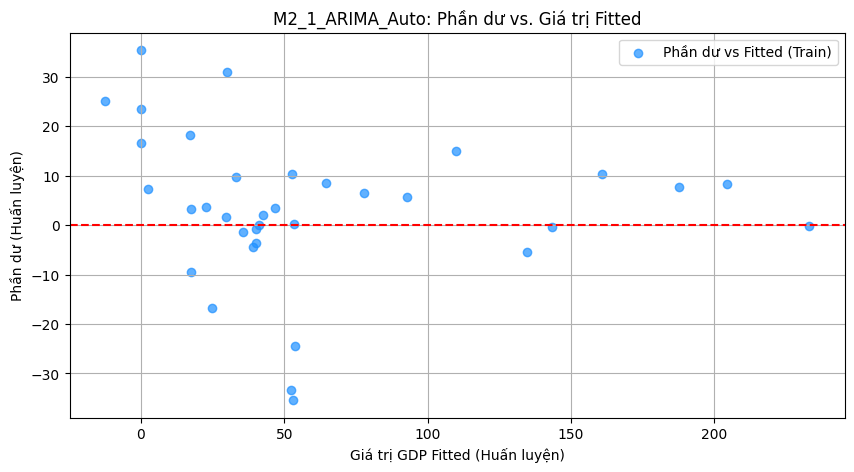

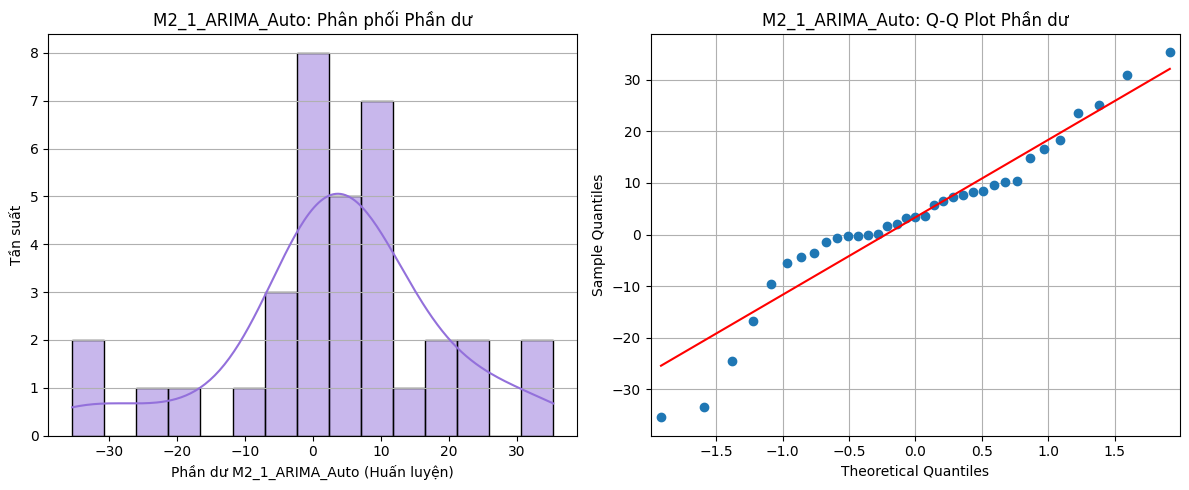

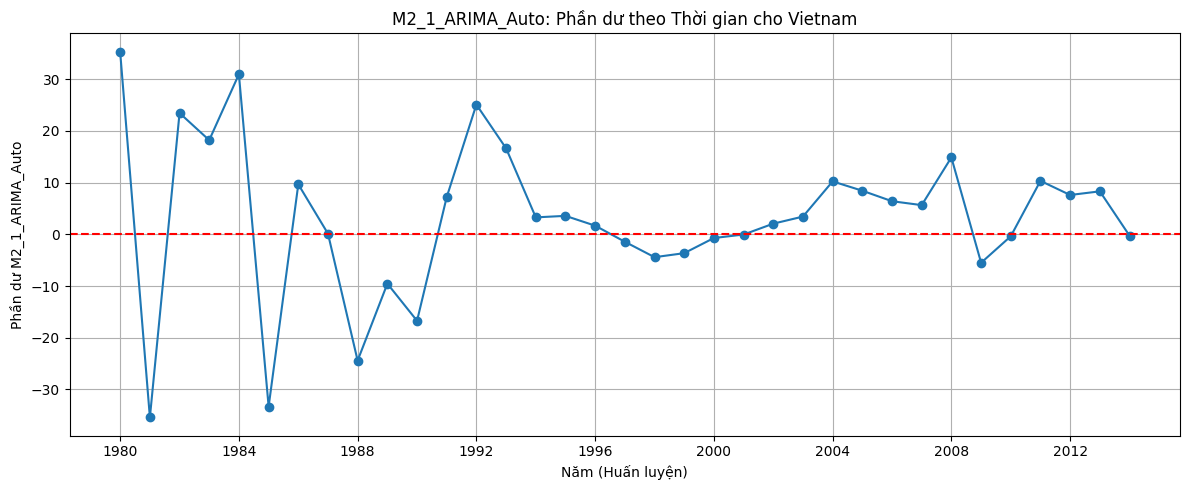

<Figure size 1000x400 with 0 Axes>

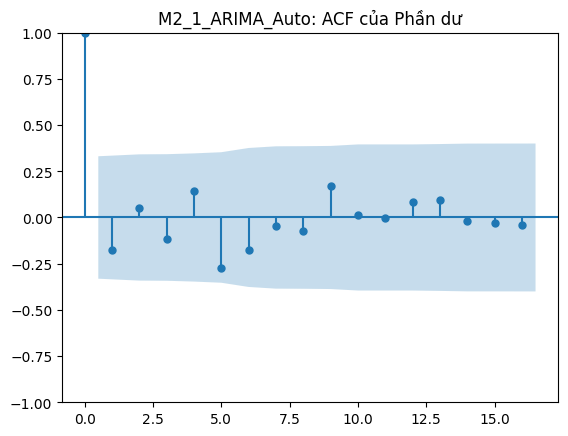


M2_1_ARIMA_Auto: Kiểm định Ljung-Box cho phần dư:


,lb_stat,lb_pvalue
10,9.198,0.513


  Phần dư có vẻ độc lập.


In [63]:
# --- CELL A4: {MODEL_ID} - PHÂN TÍCH PHẦN DƯ ---

if 'arima_results' in locals() and arima_results is not None: 
    print(f"\n\n--- {MODEL_ID}: PHÂN TÍCH PHẦN DƯ CHO {COUNTRY_TO_ANALYZE.upper()} ---")
    residuals = arima_results.resid 
    fitted_values_train = arima_results.fittedvalues 
    
    plt.figure(figsize=(10, 5))
    plt.scatter(fitted_values_train, residuals[fitted_values_train.index], alpha=0.7, label='Phần dư vs Fitted (Train)', color='dodgerblue')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('Giá trị GDP Fitted (Huấn luyện)'); plt.ylabel('Phần dư (Huấn luyện)')
    plt.title(f'{MODEL_ID}: Phần dư vs. Giá trị Fitted'); plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)
    sns.histplot(residuals, bins=15, kde=True, edgecolor='black', color='mediumpurple')
    plt.xlabel(f'Phần dư {MODEL_ID} (Huấn luyện)'); plt.ylabel('Tần suất'); plt.title(f'{MODEL_ID}: Phân phối Phần dư'); plt.grid(axis='y');
    plt.subplot(1, 2, 2); sm.qqplot(residuals, line='s', ax=plt.gca()); plt.title(f'{MODEL_ID}: Q-Q Plot Phần dư'); plt.grid(True)
    plt.tight_layout(); plt.show()

    idx_resid = residuals.index.to_timestamp() if isinstance(residuals.index, pd.PeriodIndex) else residuals.index
    plt.figure(figsize=(12, 5)); plt.plot(idx_resid, residuals, marker='o', linestyle='-')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('Năm (Huấn luyện)'); plt.ylabel(f'Phần dư {MODEL_ID}')
    plt.title(f'{MODEL_ID}: Phần dư theo Thời gian cho {COUNTRY_TO_ANALYZE}'); plt.grid(True); plt.tight_layout(); plt.show()

    lags_acf = min(20, max(1, len(residuals)//2 - 1))
    if lags_acf > 0 and len(residuals) > lags_acf :
        plt.figure(figsize=(10, 4)); plot_acf(residuals, lags=lags_acf, title=f'{MODEL_ID}: ACF của Phần dư'); plt.show()
    else: print(f"Không đủ dữ liệu phần dư cho ACF của {MODEL_ID}.")
    
    try:
        lags_lj = min(10, max(1, len(residuals)//2 -1 ))
        if lags_lj > 0 and len(residuals) > lags_lj :
             lj_box = sm.stats.acorr_ljungbox(residuals, lags=[lags_lj], return_df=True) # Sửa lại cách truyền lags
             print(f"\n{MODEL_ID}: Kiểm định Ljung-Box cho phần dư:"); display(lj_box)
             if not lj_box.empty and lj_box['lb_pvalue'].iloc[0] > 0.05: print("  Phần dư có vẻ độc lập.")
             elif not lj_box.empty: print("  Phần dư có thể còn tự tương quan.")
        else: print(f"Không đủ dữ liệu phần dư cho Ljung-Box của {MODEL_ID}.")
    except Exception as e: print(f"Lỗi Ljung-Box cho {MODEL_ID}: {e}")
else:
    print(f"Kết quả mô hình {MODEL_ID} (arima_results) chưa có.")


--- M2_1_ARIMA_Auto: HUẤN LUYỆN LẠI TRÊN TOÀN BỘ DỮ LIỆU CỦA VIETNAM ---

--- M2_1_ARIMA_Auto: Tóm tắt Mô hình ARIMA Cuối cùng ---
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   44
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -169.673
Date:                Mon, 26 May 2025   AIC                            347.345
Time:                        00:15:58   BIC                            354.296
Sample:                    12-31-1980   HQIC                           349.893
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8757      0.106     -8.272      0.000      -1.083      -0.668

,Predicted_GDP_M2_1_ARIMA_Auto
2024,495.150
2025,529.100
2026,575.616
2027,618.962
2028,651.160


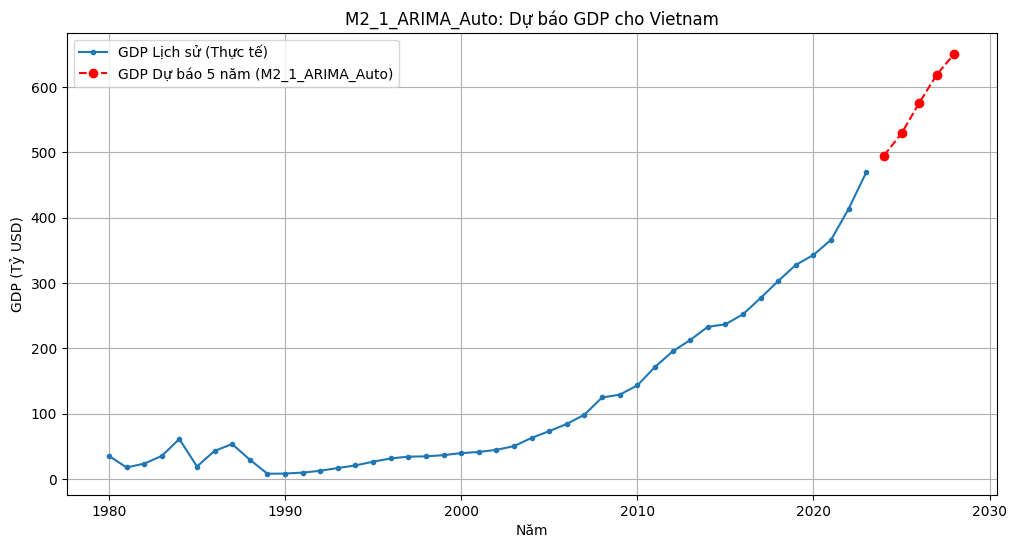


--- KẾT THÚC M2_1_ARIMA_Auto ---


In [64]:
# --- CELL A5: {MODEL_ID} - HUẤN LUYỆN LẠI VÀ DỰ BÁO TƯƠNG LAI ---

arima_results_final = None 
forecast_arima_future = None

if 'ts_gdp' in locals() and ts_gdp is not None and \
   'best_order' in locals() and best_order is not None and not ts_gdp.empty:
    
    print(f"\n--- {MODEL_ID}: HUẤN LUYỆN LẠI TRÊN TOÀN BỘ DỮ LIỆU CỦA {COUNTRY_TO_ANALYZE.upper()} ---")
    try:
        model_arima_final = StatsmodelsARIMA(ts_gdp, order=best_order)
        arima_results_final = model_arima_final.fit()
        print(f"\n--- {MODEL_ID}: Tóm tắt Mô hình ARIMA Cuối cùng ---")
        print(arima_results_final.summary())

        forecast_arima_future = arima_results_final.forecast(steps=N_FUTURE_YEARS) # Sử dụng N_FUTURE_YEARS
        
        last_year_idx = ts_gdp.index[-1]
        if isinstance(last_year_idx, pd.Period):
            future_idx = pd.period_range(start=last_year_idx + 1, periods=N_FUTURE_YEARS, freq=last_year_idx.freq)
        elif isinstance(last_year_idx, pd.Timestamp):
            future_idx = pd.date_range(start=last_year_idx + pd.DateOffset(years=1), periods=N_FUTURE_YEARS, freq=pd.DateOffset(years=1))
        else: 
            future_idx = pd.Index(range(int(last_year_idx) + 1, int(last_year_idx) + 1 + N_FUTURE_YEARS))
        forecast_arima_future.index = future_idx

        print(f"\n--- {MODEL_ID}: Dự báo GDP cho {N_FUTURE_YEARS} năm tương lai ---")
        df_forecast = forecast_arima_future.to_frame(name=f'Predicted_GDP_{MODEL_ID}')
        display(df_forecast)

        plt.figure(figsize=(12,6))
        idx_hist = ts_gdp.index.to_timestamp() if isinstance(ts_gdp.index, pd.PeriodIndex) else ts_gdp.index
        idx_future = forecast_arima_future.index.to_timestamp() if isinstance(forecast_arima_future.index, pd.PeriodIndex) else forecast_arima_future.index
        plt.plot(idx_hist, ts_gdp, label='GDP Lịch sử (Thực tế)', marker='.')
        plt.plot(idx_future, forecast_arima_future, label=f'GDP Dự báo {N_FUTURE_YEARS} năm ({MODEL_ID})', color='red', linestyle='--', marker='o')
        plt.title(f'{MODEL_ID}: Dự báo GDP cho {COUNTRY_TO_ANALYZE}'); plt.xlabel('Năm'); plt.ylabel('GDP (Tỷ USD)'); plt.legend(); plt.grid(True); plt.show()
    except Exception as e:
        print(f"Lỗi khi huấn luyện lại hoặc dự báo với mô hình {MODEL_ID} cuối cùng: {e}")
else:
    print(f"Dữ liệu hoặc tham số cho {MODEL_ID} chưa sẵn sàng để huấn luyện lại và dự báo.")
print(f"\n--- KẾT THÚC {MODEL_ID} ---")